# Critical Mineral Screening tool

The critical minerals screening tool evaluates whether the current produced water network has lithium recovery capabilities. In this notebook we will learn how to use the screening tool to determine the following:
1. Does current infrastructure and placement of the treatment site facilitate lithium recovery?
2. Is the current infrastructure hindering the lithium recovery opportunities?
3. What is the optimal location to install the treatment facility within the network?


Module Overview:
1. Load and View Data
2. Run current model
3. Run a comparison between the maximum theoretical revenue with and without existing infrastructure
4. Identify the optimal location for desalination installation


### DISCLAIMER:
PARETO was produced under the DOE Produced Water Application for Beneficial Reuse Environmental
Impact and Treatment Optimization (PARETO), and is copyright (c) 2021-2024 by the software owners:
The Regents of the University of California, through Lawrence Berkeley National Laboratory, et al.
All rights reserved.

NOTICE. This Software was developed under funding from the U.S. Department of Energy and the U.S.
Government consequently retains certain rights. As such, the U.S. Government has been granted for
itself and others acting on its behalf a paid-up, nonexclusive, irrevocable, worldwide license in
the Software to reproduce, distribute copies to the public, prepare derivative works, and perform
publicly and display publicly, and to permit others to do so.

In [1]:
## Imports
import pyomo.environ as pyo
from pareto.other_models.CM_module.models.qcp_br import build_qcp_br
from pareto.utilities.get_data import get_data
from pareto.utilities.cm_utils.gen_utils import report_results_to_excel
from pareto.utilities.cm_utils.opt_utils import (
    max_theoretical_recovery_flow_opt,
    cost_optimal,
    max_recovery_with_infrastructure,
)
from pareto.utilities.cm_utils.run_utils import (
    load_data,
    print_results_summary,
    solving,
    node_rerun,
)
from pareto.utilities.cm_utils.data_parser import data_parser

from importlib import resources
from set_param_list import set_list, parameter_list

In this notebook we will show the implementation of the screening tool on the small_case_study. You can also run the problem on another pre-loaded case study: large_case_study_Li or develop your own case study.

In [2]:
# Loading data
# In this problem we are going to use the toy case study
with resources.path(
    "pareto.case_studies",
    "small_case_study_Li.xlsx",  # change this to large_case_study_Li if you want to try the other case study
) as fpath:
    # Obtaining data from excel file
    [df_sets, df_parameters] = get_data(fpath, set_list, parameter_list)

# Parsing the data to make it in the model format
data = data_parser(df_sets, df_parameters)

/var/folders/cv/k__j34c95hx5fn2w99_0by100000gn/T/ipykernel_18348/3692034319.py:8: UserWarning: Units is not found in defined sets or parameters but is parsed in the input data
  [df_sets, df_parameters] = get_data(fpath, set_list, parameter_list)
/var/folders/cv/k__j34c95hx5fn2w99_0by100000gn/T/ipykernel_18348/3692034319.py:8: UserWarning: ProductionTanks is not found in defined sets or parameters but is parsed in the input data
  [df_sets, df_parameters] = get_data(fpath, set_list, parameter_list)
/var/folders/cv/k__j34c95hx5fn2w99_0by100000gn/T/ipykernel_18348/3692034319.py:8: UserWarning: DesalinationTechnologies is not found in defined sets or parameters but is parsed in the input data
  [df_sets, df_parameters] = get_data(fpath, set_list, parameter_list)


## Base case

Now we will show how the model performs on the pre-loaded base case with the desalination facility installed at N03. 
The goal of this model is to minimize operating costs given possible lithium recovery revenue and beneficial reuse revenue while ensuring that at every time period at least 100 mg/L Li concentrated water exits the desalination facility.

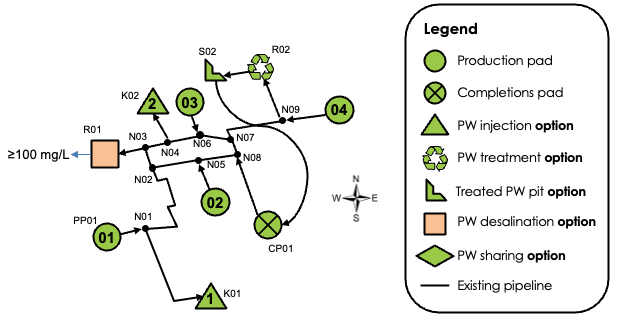

In [3]:
model = build_qcp_br(data)

# solving and displaying cost breakdown
model, _ = solving(model, tee=False)  # make tee=True if you want to see solver logs


Developing an initialization...

Solving bilinear problem...

 Successfully solved model
Arc cost:                               4269
Disposal cost:                       1103541
Freshwater cost:                     5302452
Treatment cost:                      1722170
Storage cost:                        1755032
Storage revenue:                     1737482
Lithium revenue:                      513365
Beneficial Reuse Revenue:             410692
Net cost:                            7225926


The model solved successfully which means that lithium recovery opportunities exist given the current infrastructure. Now we will try to assess whether more lithium revenue is possible.

## Assessing lithium revenue possibilities

Now we will try to assess whether the current infrastructure is hindering lithium revenue opportunities. 

In the next block we will rerun the model, but this time to maximize lithium revenue without considering the impact that has on other operating costs.

In [4]:
max_inf_model = max_recovery_with_infrastructure(data)
print_results_summary(max_inf_model)

   ... running linear flow model
   ... running bilinear model
Max lithium revenue with existing infrastructure: 870608.1283902546
Arc cost:                              71795
Disposal cost:                       1117956
Freshwater cost:                     7751282
Treatment cost:                      2255071
Storage cost:                         314202
Storage revenue:                      214870
Lithium revenue:                      870608
Beneficial Reuse Revenue:             696487
Net cost:                            9728341


As we can see the maximum Lithium revenue that can be attained given the existing infrastructure is $8,70,608/yr. 

Now we will compare this number to the maximum theoretical Li revenue that can be obtained from this network if we disregard the existing infrastructure.

In [5]:
max_recovery = max_theoretical_recovery_flow_opt(
    model,
    treatment_unit="R01_IN",  # change R01 if you want to consider a different treatment unit
    desired_li_conc=100,
)

# Displaying difference between max possible lithium revenue with and without existing infrastructure
print(
    f"Max. lithium revenue with\n existing infrastructure:  "
    f"{pyo.value(max_inf_model.treat_rev):>8.0f}"
)
print()
print(
    f"Max theoretical treatment revenue\n (ignoring infrastructure): "
    f"{max_recovery:>8.0f}"
)

Max. lithium revenue with
 existing infrastructure:    870608

Max theoretical treatment revenue
 (ignoring infrastructure):  1173483


As we can see the current infrastructure is not proving to be a major hindrance. 

## Optimal treatment facility location
What if we want to see which node within the network is the best location for installing the desalination facility?
In this section, we show how our model can tell the user which is the best location to install the desalination facility. We rerun the operational model by attaching the specified desalination facility at each node of the network. At the end, we compare which node led to the minimum costs.

Warning: This problem can take a long time to run. The small case study takes 8-10 mins and the large case study takes 20-25 mins




making new models

model N01 being made...
model N02 being made...
model N03 being made...
model N04 being made...
model N05 being made...
model N06 being made...
model N07 being made...
model N08 being made...
model N09 being made...

models generated





Running N01


Developing an initialization...

Solving bilinear problem...

 Successfully solved model
Arc cost:                              19370
Disposal cost:                       1244530
Freshwater cost:                     5502050
Treatment cost:                      1570657
Storage cost:                        1621967
Storage revenue:                     1605747
Lithium revenue:                      466066
Beneficial Reuse Revenue:             372853
Net cost:                            7513908


Running N02


Developing an initialization...

Solving bilinear problem...

 Successfully solved model
Arc cost:                               9532
Disposal cost:                       1244530
Freshwater cost:                    

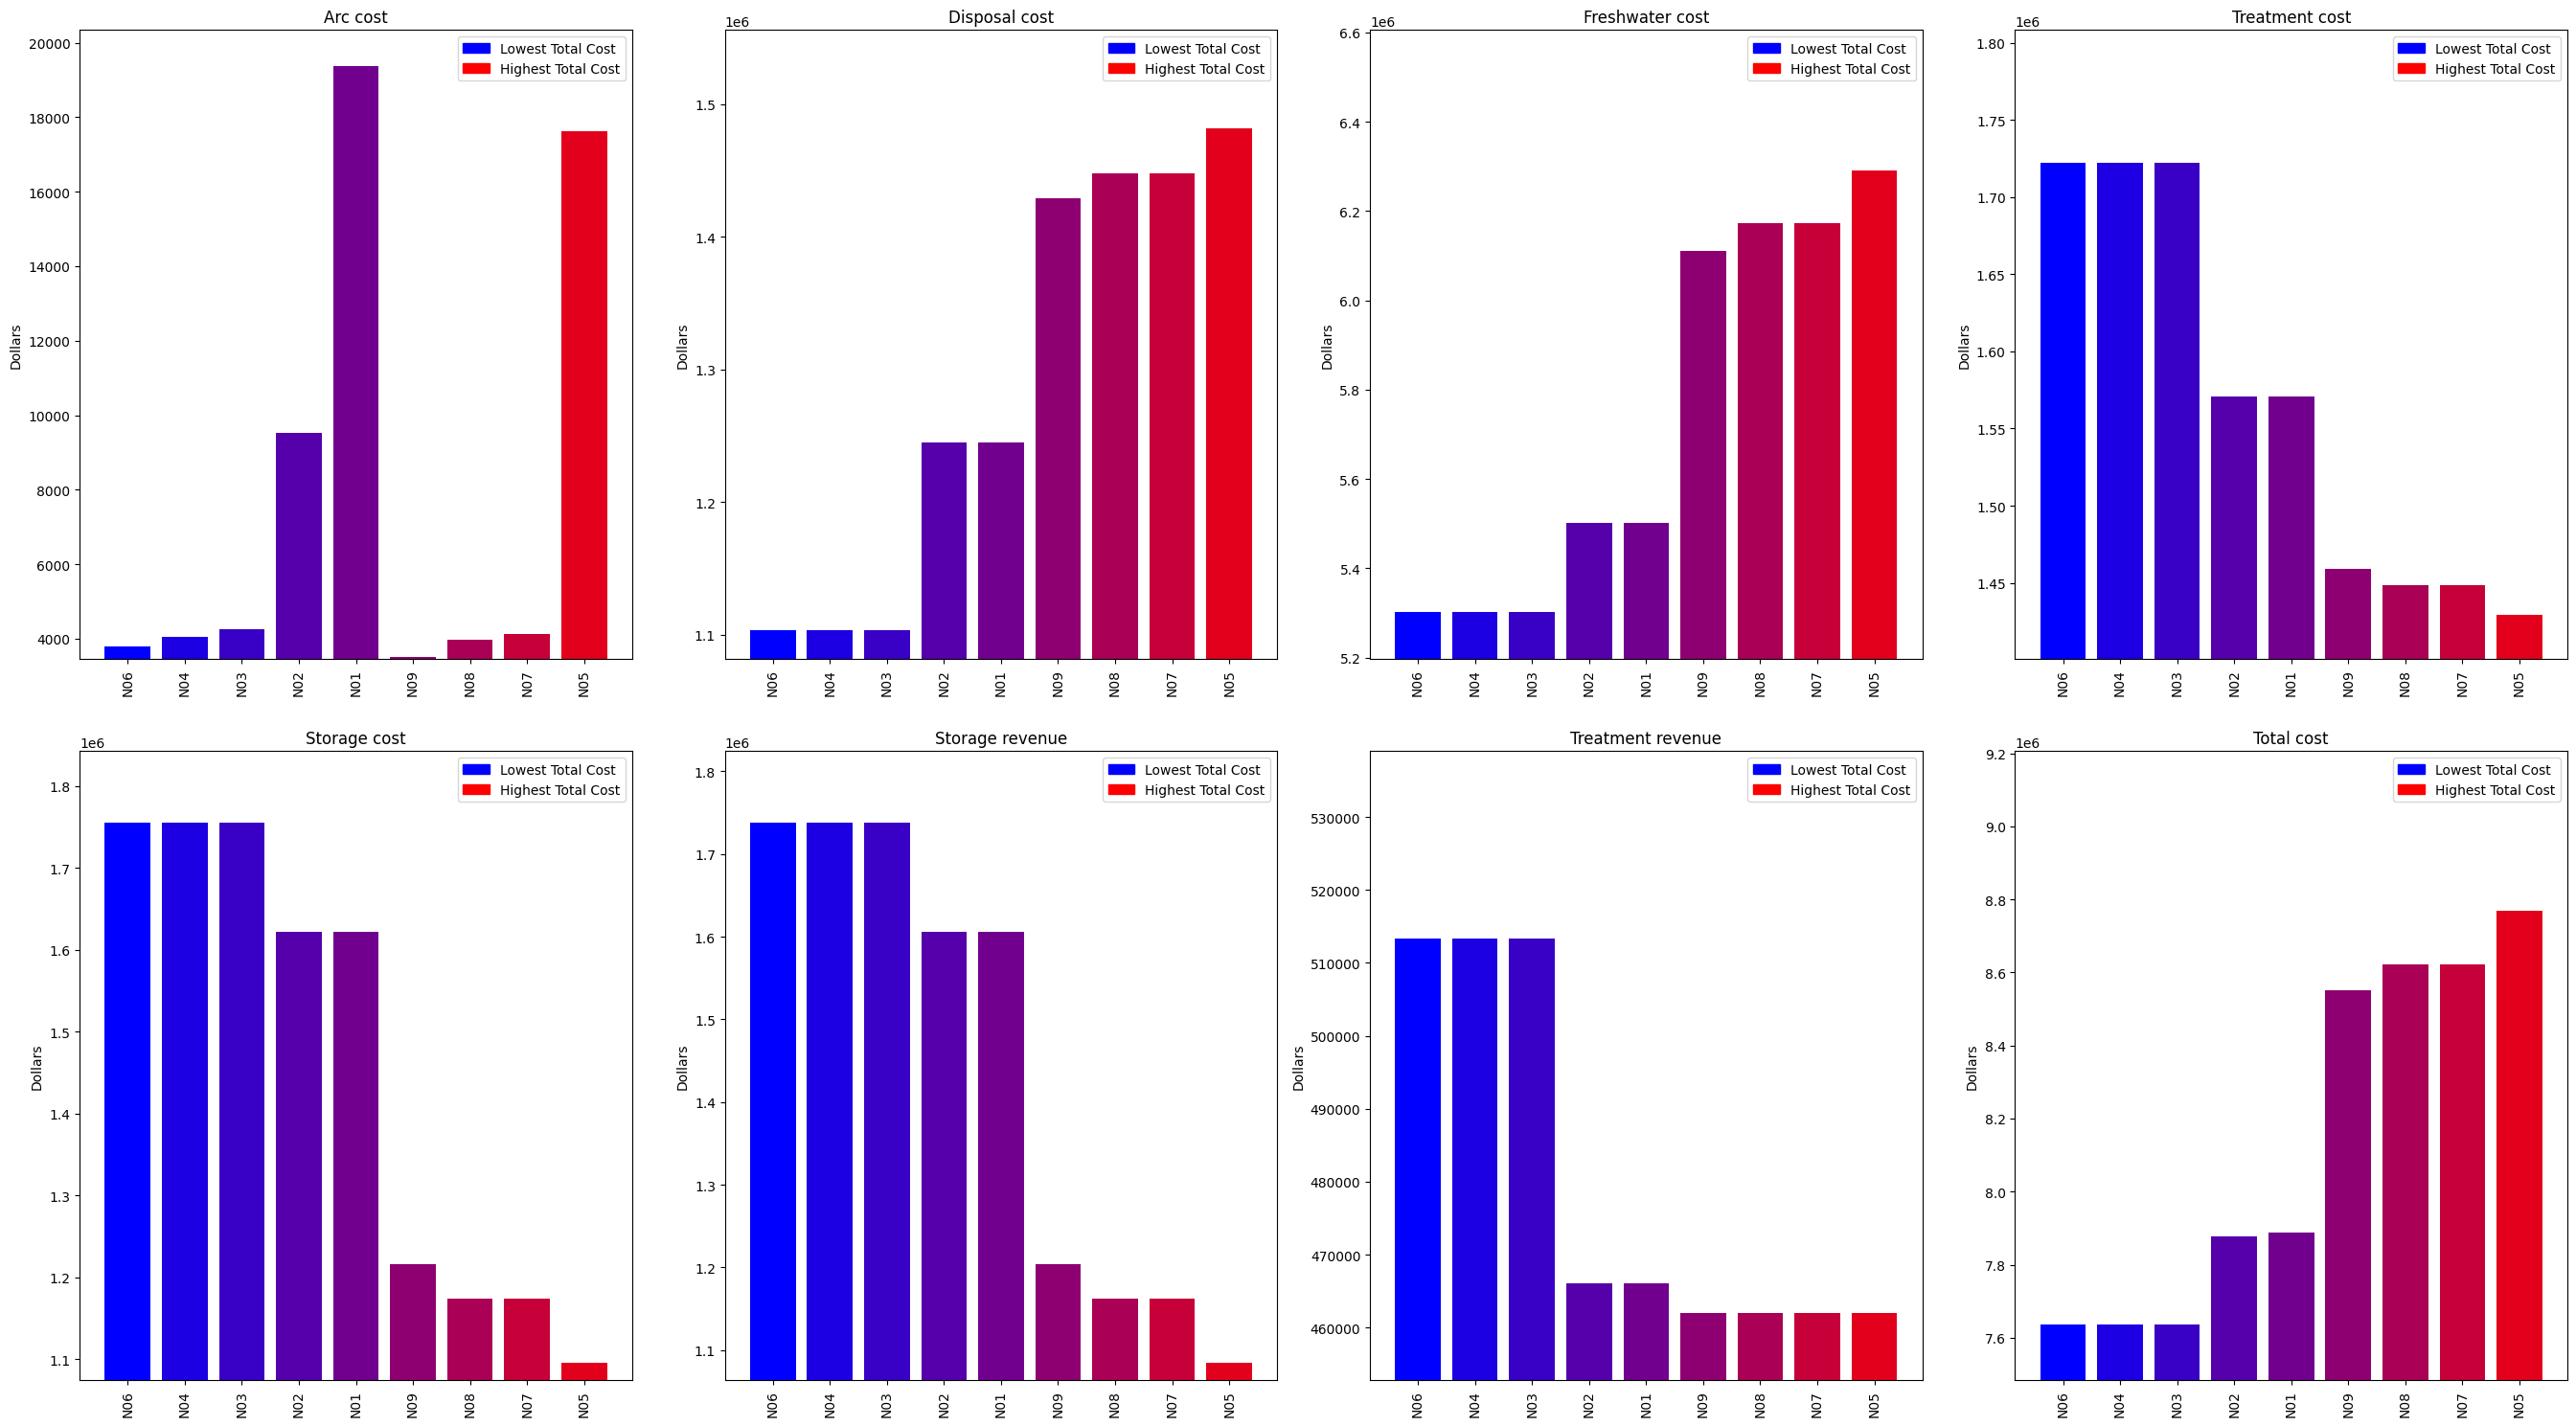

In [6]:
min_node, models = node_rerun(
    df_sets, df_parameters, treatment_site="R01", max_iterations=5000
)
final_model = models[min_node]
print()
print(f"*** Lowest cost location for treatment ***")

# Displaying specific broken down costs
print_results_summary(final_model)

Turns out N03 wasn't the best location to install the desalination facility rather N06 is the optimal installation location. This makes sense because N06 is next to a high lithium concentration production pad.

### Storing results

We can store the flow, concentration, and inventory results in an Excel within your current directory.

In [7]:
fname = "small_case_study_Li"

# change final_model to any model you want to store. Here we store
report_results_to_excel(
    final_model, filename=f"{fname}_operational_results.xlsx", split_var={"s_A": 3}
)
print("Results stored")

Results stored


## Let's talk about infeasibility

There would be cases where the model is infeasible. Let's see how the output would be in those cases.



We will change the minimum lithium concentration requirement. Before doing that let's look at what the existing Li requirement is.

In [8]:
# We will change the minimum lithium concentration requirement to force infeasibility

print(data["p_Cmin"])

{('R01_CW', 'TDS'): 0, ('R01_CW', 'Li'): 100, ('R02_CW', 'TDS'): 0, ('R02_CW', 'Li'): 0}


On the backend we change the treatment facility to a three-node network as shown below. R01_CW stands for the concentrated water stream exiting the treatment facility.

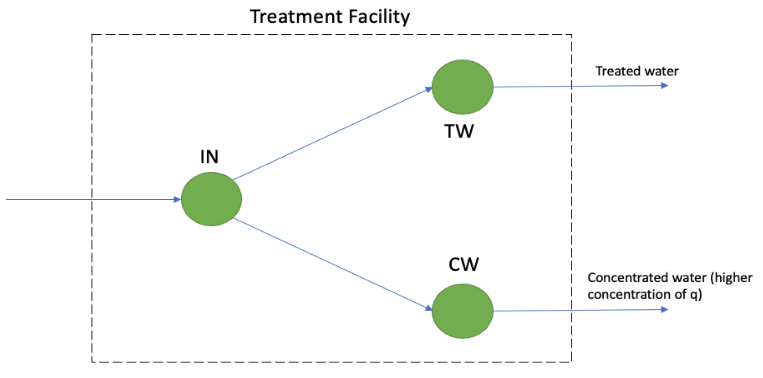

Now let's change the minimum Li concentration from 100 to 150 for R01

In [9]:
data["p_Cmin"]["R01_CW", "Li"] = 150
print(data["p_Cmin"])

{('R01_CW', 'TDS'): 0, ('R01_CW', 'Li'): 150, ('R02_CW', 'TDS'): 0, ('R02_CW', 'Li'): 0}


In [10]:
model = build_qcp_br(data)

# solving and displaying cost breakdown
model, _ = solving(model, tee=False, inf_recs=True)  # make inf_recs=False if you don't want to see feasibility recommendations


Developing an initialization...

Solving bilinear problem...
model.name="unknown";
    - termination condition: infeasible
    - message from solver: Ipopt 3.13.2\x3a Converged to a locally infeasible
      point. Problem may be infeasible.
Model is Infeasible
                The model is infeasible. Some possible reasons for infeasibility: 
                 1. The minimum CM recovery concentration is too high given the existing infrastructure and parameters 
                 2. The produced water concentration is too low to meet minimum CM concentration requirements 
                 3. The treatment efficiency is not sufficient to meet the minimum CM concentration 
                 4. Installation of pipelines for direct transportation of water from high CM concentration production pads to desalination sites would aid feasibility 
                 


This model turned out to be infeasible. In produced water networks the infeasibility usually arises due to the minimum concentration constraint. If the model is infeasible we provide recommendations on how to obtain feasibility.